Loading data.npy

In [2]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,confusion_matrix
from numpy.linalg import norm

data = np.load("data.npy",allow_pickle=True)
print(len(data))

1500


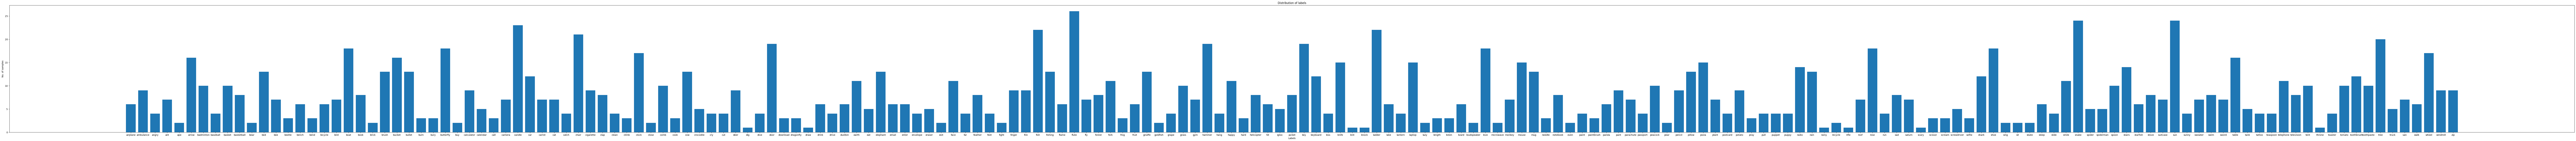

In [3]:
from matplotlib import pyplot as plt

column = data[:, 3]
x,y = np.unique(column,return_counts = True)

fig = plt.figure(figsize =(200, 10))
# Function to plot the bar
plt.bar(x,y)
# function to show the plot
plt.xlabel("Labels")
plt.ylabel("No. of samples")
plt.title("Distribution of labels")
plt.show()

Initial KNN

In [4]:
class KNN:
    def __init__(self, k, distance_metric, encoder_type):
        self.k = k
        self.distance_metric = distance_metric
        self.encoder_type = encoder_type
        self.train_x = None
        self.train_y = None
    
    def train(self,data1):
        if(self.encoder_type == 'RESNET'):
            self.train_x = data1[:,1]
            self.train_y = data1[:,3]
        if(self.encoder_type == 'VIT'):
            self.train_x = data1[:,2]
            self.train_y = data1[:,3]

    def predict(self, test_x):
        predictions=[]
        for x in test_x:
            distance = []
            for x1 in self.train_x:
                distance.append(self.get_distance(np.array(x[0]),np.array(x1[0])))
            distance = np.array(distance) 
            dist = np.argsort(distance)[:self.k] 
            labels = self.train_y[dist]
            predictions.append(max(list(labels), key = list(labels).count))
        return predictions

    def get_distance(self,x,x1):
        if(self.distance_metric=="euclidean"):
            dist = np.sqrt(np.sum((x-x1)**2))
        if(self.distance_metric=="manhattan"):
            dist = np.sum(np.abs(x-x1))
        if(self.distance_metric=="cosine"):
            dist = 1-(np.dot(x,x1)/(norm(x)*norm(x1)))
        return dist
    
    def validate(self,data1):
        if(self.encoder_type == 'RESNET'):
            val_x = data1[:,1]
            val_y = data1[:,3]
        if(self.encoder_type == 'VIT'):
            val_x = data1[:,2]
            val_y = data1[:,3]
        predictions = self.predict(val_x)
        f1 = f1_score(val_y, predictions, average='macro')
        accuracy = accuracy_score(val_y, predictions)
        precision = precision_score(val_y, predictions, average='macro',zero_division=np.nan)
        recall = recall_score(val_y, predictions, average='macro',zero_division=np.nan)
        return f1, accuracy, precision,recall



Splitting dataset

In [5]:
# Determine the split index
split_idx = int(data.shape[0] * 0.8)  # adjust the split ratio as needed

# Shuffle the dataset
np.random.shuffle(data)

# Split the dataset
train = data[:split_idx]
val = data[split_idx:]

Hyperparameter Tuning

In [17]:
res = []
encoder = ['RESNET','VIT']
metric = ['euclidean','manhattan','cosine']
for e in encoder:
    for m in metric:
        for i in range(1,35):
            knn = KNN(encoder_type= e, k=i, distance_metric=m)
            knn.train(train)
            f,a,p,r=knn.validate(val)
            res.append([a,e,i,m])


In [ ]:
s = sorted(res, key=lambda x: x[0], reverse=True)

for i in range(0,20):
    print(s[i][1], s[i][2], s[i][3], s[i][0])

Optimized KNN

In [6]:
class OP_KNN(KNN):
    def __init__(self, k, distance_metric, encoder_type):
        super().__init__(k, distance_metric, encoder_type)
    
    def predict(self, test_x):
        predictions=[]
        t = np.array([train[0] for train in self.train_x])
        for x in test_x:
            distance = self.get_distance(np.array(x[0]),np.array(t))
            distance = np.array(distance) 
            dist = np.argsort(distance)[:self.k] 
            labels = self.train_y[dist]
            predictions.append(max(list(labels), key = list(labels).count))
        return predictions

    def get_distance(self,x,t):
        if(self.distance_metric=="euclidean"):
            dist = np.sqrt(np.sum((t- x) ** 2, axis=1))
        if(self.distance_metric=="manhattan"):
            dist = np.sum(np.abs((t - x)),axis=1)
        if(self.distance_metric=="cosine"):
            dist = 1-(np.dot(t,x)/(norm(x)*norm(t,axis=1)))
        return dist

Hyperparameter Tuning Using Optimized KNN

In [7]:
res = []
encoder = ['RESNET','VIT']
metric = ['euclidean','manhattan','cosine']
for e in encoder:
    for m in metric:
        for i in range(1,35):
            knn = OP_KNN(encoder_type= e, k=i, distance_metric=m)
            knn.train(train)
            f,a,p,r=knn.validate(val)
            res.append([a,e,i,m])

s = sorted(res, key=lambda x: x[0], reverse=True)

for i in range(0,20):
    print(s[i][1], s[i][2], s[i][3], s[i][0])

VIT 13 euclidean 0.27
VIT 14 euclidean 0.2633333333333333
VIT 12 euclidean 0.26
VIT 11 euclidean 0.25666666666666665
VIT 13 manhattan 0.25333333333333335
VIT 9 euclidean 0.25
VIT 11 manhattan 0.25
VIT 12 manhattan 0.25
VIT 14 manhattan 0.25
VIT 9 cosine 0.25
VIT 10 euclidean 0.24666666666666667
VIT 4 manhattan 0.24666666666666667
VIT 16 manhattan 0.24666666666666667
VIT 22 manhattan 0.24666666666666667
VIT 30 manhattan 0.24666666666666667
VIT 10 cosine 0.24666666666666667
VIT 17 cosine 0.24666666666666667
VIT 19 cosine 0.24666666666666667
VIT 15 euclidean 0.24333333333333335
VIT 10 manhattan 0.24333333333333335


K vs ACCURACY

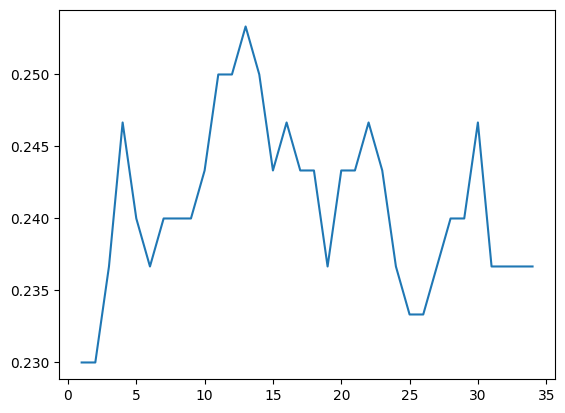

In [8]:
x = []
y = []

for i in range(1,35):
    knn = OP_KNN(encoder_type= 'VIT', k=i, distance_metric='manhattan')
    knn.train(train)
    f,a,p,r=knn.validate(val)
    x.append(i)
    y.append(a)
plt.plot(x, y)
plt.show()

Inference time for initial KNN model, best KNN model, most optimized KNN model, and the default sklearn KNN model.

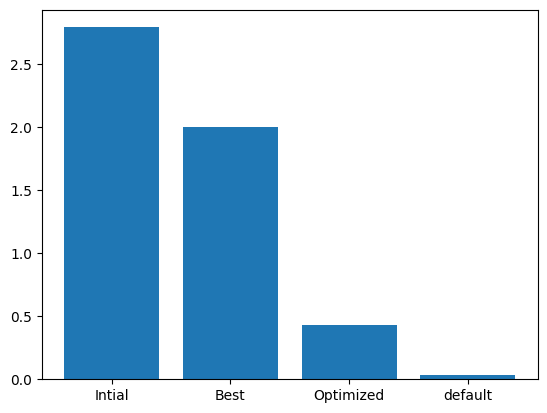

In [9]:
import time
from sklearn.neighbors import KNeighborsClassifier

x = ["Intial", "Best", "Optimized", "default"]
y = []

# Best KNN
start_time = time.time()
knn = KNN(encoder_type= 'RESNET', k=5, distance_metric='euclidean')
knn.train(train)
knn.validate(val)
end_time = time.time()
y.append(end_time-start_time)

# Best KNN
start_time = time.time()
knn = KNN(encoder_type= 'VIT', k=11, distance_metric='manhattan')
knn.train(train)
knn.validate(val)
end_time = time.time()
y.append(end_time-start_time)

# Optimized KNN
start_time = time.time()
knn = OP_KNN(encoder_type= 'VIT', k=11, distance_metric='manhattan')
knn.train(train)
knn.validate(val)
end_time = time.time()
y.append(end_time-start_time)

X_train = train[:,2]
X_test = val[:,2]
t = np.array([train[0] for train in X_train])
t1 = np.array([val[0] for val in X_test])

# Default sklearn KNN
start_time = time.time()
clf = KNeighborsClassifier(n_neighbors = 11)
clf.fit(t, train[:,3])
test_score = clf.score(t1, val[:,3])
end_time = time.time()
y.append(end_time-start_time)
plt.bar(x,y)
plt.show()

Inference time vs train dataset size for initial KNN model, best KNN model, most optimized KNN model, and the default sklearn KNN model.

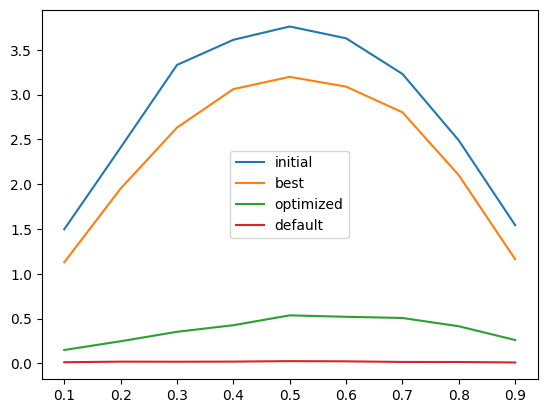

In [10]:
import time
from sklearn.neighbors import KNeighborsClassifier

x = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
y = []

# Initial KNN
for i in x:
    split_idx1 = int(data.shape[0] * i)
    np.random.shuffle(data)
    train1 = data[:split_idx1]
    val1 = data[split_idx1:]
    start_time = time.time()
    knn = KNN(encoder_type= 'RESNET', k=5, distance_metric='euclidean')
    knn.train(train1)
    knn.validate(val1)
    end_time = time.time()
    y.append(end_time-start_time)

plt.plot(x, y, label = "initial")
y =[]

# Best KNN
for i in x:
    split_idx1 = int(data.shape[0] * i)
    np.random.shuffle(data)
    train1 = data[:split_idx1]
    val1 = data[split_idx1:]
    start_time = time.time()
    knn = KNN(encoder_type= 'VIT', k=11, distance_metric='manhattan')
    knn.train(train1)
    knn.validate(val1)
    end_time = time.time()
    y.append(end_time-start_time)

plt.plot(x, y, label = "best")
y =[]

# Optimized KNN
for i in x:
    split_idx1 = int(data.shape[0] * i)
    np.random.shuffle(data)
    train1 = data[:split_idx1]
    val1 = data[split_idx1:]
    start_time = time.time()
    knn = OP_KNN(encoder_type= 'VIT', k=11, distance_metric='manhattan')
    knn.train(train1)
    knn.validate(val1)
    end_time = time.time()
    y.append(end_time-start_time)

plt.plot(x, y, label = "optimized")
y =[]

# Default sklearn KNN
for i in x:
    split_idx1 = int(data.shape[0] * i)
    np.random.shuffle(data)
    train1 = data[:split_idx1]
    val1 = data[split_idx1:]
    X_train = train1[:,2]
    X_test = val1[:,2]
    t = np.array([train[0] for train in X_train])
    t1 = np.array([val[0] for val in X_test])
    start_time = time.time()
    clf = KNeighborsClassifier(n_neighbors = 11)
    clf.fit(t, train1[:,3])
    test_score = clf.score(t1, val1[:,3])
    end_time = time.time()
    y.append(end_time-start_time)
plt.plot(x, y, label = "default")
plt.legend()
plt.show()

DECISION TREES

In [11]:
# Import pandas
import pandas as pd
# reading csv file
df = pd.read_csv('advertisement.csv')

PowerSet Formulation

In [12]:
import itertools

labels = df['labels'].str.split(' ').explode().unique()

powerset = []
for i in range(len(labels) + 1):
    for combination in itertools.combinations(labels, i):
        powerset.append(list(combination))


In [13]:
labels = df['labels'].str.split()
y = []
for l in labels:
    for i in range(0,len(powerset)):
        if(set(l)==set(powerset[i])):
            y.append(i)
            break

In [14]:
from sklearn.preprocessing import OneHotEncoder
columns_to_encode = ['age', 'gender', 'income','education','married','children','city','occupation','purchase_amount','most bought item']
encoder = OneHotEncoder()
encoder.fit(df[columns_to_encode])
x = x1 = encoder.transform(df[columns_to_encode]).toarray()

Decision Tree Classifier Class with the Powerset Formulation

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

class DT:
    def __init__(self, max_depth, max_features, criterion):
        self.max_depth = max_depth
        self.max_features = max_features
        self.criterion = criterion
        self.train_x = None
        self.train_y = None
        self.test_x = None
        self.test_y = None
    
    def train(self,x,y):
        self.train_x, self.test_x, self.train_y, self.test_y = train_test_split(x, y, test_size=0.2, random_state=42)
    
    def score(self,is_multioutput):
        classifier = DecisionTreeClassifier(max_depth=self.max_depth, max_features=self.max_features, criterion=self.criterion)
        classifier.fit(self.train_x, self.train_y)
        y_pred = classifier.predict(self.test_x)
        if(is_multioutput):
            y_pred = [''.join(str(j) for j in i) for i in y_pred]
            self.test_y = [''.join(str(j) for j in i) for i in self.test_y]
        accuracy = accuracy_score(self.test_y, y_pred)
        precision = precision_score(self.test_y, y_pred, average="macro",zero_division=np.nan)
        f1_micro = f1_score(self.test_y, y_pred, average="micro")
        f1_macro = f1_score(self.test_y, y_pred, average="macro")
        recall = recall_score(self.test_y, y_pred, average="macro",zero_division=np.nan)
        confusion_mat = confusion_matrix(np.array(self.test_y), y_pred)
        return accuracy,precision,f1_micro,f1_macro,recall,confusion_mat

In [16]:
dt = DT(3,5,"gini")
dt.train(x,y)
print(dt.score(False))

(0.025, 0.036111111111111115, 0.025000000000000005, 0.0011336445298709447, 0.009119496855345912, array([[0, 3, 1, ..., 0, 0, 0],
       [0, 4, 1, ..., 0, 0, 0],
       [0, 5, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]]))


MULTIOUTPUT FORMULATION

In [17]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=df['labels'].str.split().explode().unique())
y1 = mlb.fit_transform(labels)

In [18]:
dt1 = DT(10,10,"entropy")
dt1.train(x,y1)
print(dt1.score(True))

(0.0, 0.0, 0.0, 0.0, 0.0, array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]]))


HYPERPARAMETER TUNING WITH POWERSET

In [21]:
res = []
criterion = ["gini", "entropy"]
max_depth = [3,5,10,20,30]
max_features = [3,5,7,9,11]
for c in criterion:
    for d in max_depth:
        for f in max_features:
            d3 = DT(d,f,c)
            d3.train(x,y)
            a,p,f1_mi,f1_ma,r,c_m = d3.score(False)
            res.append([c,d,f,f1_mi,f1_ma,a,p,r,c_m])

s = sorted(res, key=lambda x: x[4], reverse=True)

for i in range(0,3):
    print(s[i][0], s[i][1], s[i][2], s[i][3], s[i][4],s[i][5], s[i][6], s[i][7], s[i][8])

gini 30 7 0.035 0.008482770524467144 0.035 0.1130487804878049 0.02358490566037736 [[0 3 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]
gini 20 9 0.05000000000000001 0.007595575518643939 0.05 0.05290195915195916 0.02106918238993711 [[0 0 4 ... 0 0 0]
 [0 2 3 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
entropy 30 3 0.025000000000000005 0.006458022851465474 0.025 0.04019014693171997 0.016981132075471698 [[0 4 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


HYPERPARAMETER TUNING WITH MULTI-OUTPUT

In [22]:
res = []
criterion = ["gini", "entropy"]
max_depth = [3,5,10,20,30]
max_features = [3,5,7,9,11]
for c in criterion:
    for d in max_depth:
        for f in max_features:
            d3 = DT(d,f,c)
            d3.train(x,y1)
            a,p,f1_mi,f1_ma,r,c_m = d3.score(True)
            res.append([c,d,f,f1_mi,f1_ma,a,p,r,c_m])

s = sorted(res, key=lambda x: x[4], reverse=True)

for i in range(0,3):
    print(s[i][0], s[i][1], s[i][2], s[i][3], s[i][4],s[i][5], s[i][6], s[i][7], s[i][8])

entropy 20 11 0.02 0.015017430946634484 0.02 0.15555555555555553 0.01320754716981132 [[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
gini 20 5 0.01 0.011695906432748537 0.01 0.06944444444444445 0.014150943396226415 [[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
gini 20 9 0.025000000000000005 0.009349060725207515 0.025 0.09242424242424242 0.014779874213836478 [[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
